# <center> Prepare and Model

# <center>Preliminaries

In [1]:
# Import Dependancies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from tensorflow import keras

import random as rn
from sklearn.metrics import mean_squared_error
import shap
from sklearn.model_selection import GridSearchCV

import joblib


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Import Data

mds = pd.read_csv("NH_QualityMsr_MDS_Aug2023.csv",
                 low_memory = False)

survey = pd.read_csv("NH_SurveySummary_Aug2023.csv")
claims = pd.read_csv("NH_QualityMsr_Claims_Aug2023.csv")
provider = pd.read_csv("NH_ProviderInfo_Aug2023.csv")

# <center> Custom Functions Defined in Exploration Notebook

In [3]:
# Create Functions for Initial Data Prep for the individual tables
# See 'Exploratory Data Analysis' notebook for walkthrough.

def mds_prep(mds):
    df = mds[mds['Resident type'] == 'Long Stay']
    return df[['CMS Certification Number (CCN)', 'Measure Description',
       'Four Quarter Average Score']]

def survey_prep(survey):
    survey_recent = survey[survey['Inspection Cycle'] == 1]
    x = survey_recent.describe().T
    zero_columns = x[(x['max'] == 0) & (x['max'] == 0)].index
    survey_dropzero = survey_recent.drop(columns = zero_columns)   
    survey_dropfire = survey_dropzero.drop(columns = ['Fire Safety Survey Date', 
                                                  'Total Number of Fire Safety Deficiencies',
                                                  'Count of Emergency Preparedness Deficiencies',
                                                  'Count of Construction Deficiencies',
                                                  'Count of Services Deficiencies',
                                                  'Count of Egress Deficiencies',
                                                  'Count of Electrical Deficiencies',
                                                  'Count of Smoke Deficiencies',
                                                  'Count of Gas and Vacuum and Electrical Systems Deficiencies',
                                                  'Count of Medical Gases and Anaesthetizing Areas Deficiencies',
                                                  'Count of Miscellaneous Deficiencies'])
    return survey_dropfire.drop(columns = ['Provider Name', 'Provider Address',
       'City/Town', 'State', 'ZIP Code', 'Inspection Cycle',
       'Health Survey Date', 'Location','Processing Date'])

def claims_prep(claims):
    claims_filtered = claims.loc[(claims['Resident type'] == 'Long Stay') & 
           (claims['Measure Description'] == 'Number of hospitalizations per 1000 long-stay resident days')]
    claims_valid = claims_filtered.dropna(subset = ['Observed Score'], ignore_index = True)
    claims_subset = claims_valid[['CMS Certification Number (CCN)', 'Provider Name', 'Provider Address',
       'City/Town', 'State', 'ZIP Code', 'Expected Score']].rename(
            columns = {'Expected Score' : 'Adjusted Hospitalization Rate'}) # Rename target column name
    return claims_subset.drop(columns = ['Provider Name', 'Provider Address',
       'City/Town', 'State', 'ZIP Code'])
    
def provider_prep(provider, null_threshold = .95):
    provider_subset = provider[['CMS Certification Number (CCN)', # Initial set of columns investigated 
       'Provider Name', 'Provider Address', 
       'City/Town', 'State', 'ZIP Code', 'Ownership Type',
       'Number of Certified Beds', 'Average Number of Residents per Day',
       'Average Number of Residents per Day Footnote', 'Provider Type',
       'Provider Resides in Hospital',
       'Continuing Care Retirement Community', 'Special Focus Status',
       'Abuse Icon', 'Most Recent Health Inspection More Than 2 Years Ago',
       'Provider Changed Ownership in Last 12 Months',
       'With a Resident and Family Council', 'Overall Rating',
       'Overall Rating Footnote', 'Health Inspection Rating',
       'Health Inspection Rating Footnote', 'QM Rating', 'QM Rating Footnote',
       'Long-Stay QM Rating', 'Long-Stay QM Rating Footnote',
       'Staffing Rating', 'Staffing Rating Footnote',
       'Reported Staffing Footnote',
       'Total nursing staff turnover', 'Total nursing staff turnover footnote',
       'Registered Nurse turnover', 'Registered Nurse turnover footnote',
       'Number of administrators who have left the nursing home',
       'Administrator turnover footnote',
       'Adjusted Nurse Aide Staffing Hours per Resident per Day',
       'Adjusted LPN Staffing Hours per Resident per Day',
       'Adjusted RN Staffing Hours per Resident per Day',
       'Adjusted Total Nurse Staffing Hours per Resident per Day',
       'Adjusted Weekend Total Nurse Staffing Hours per Resident per Day',
       'Rating Cycle 1 Standard Survey Health Date',
       'Rating Cycle 1 Total Number of Health Deficiencies',
       'Rating Cycle 1 Number of Standard Health Deficiencies',
       'Rating Cycle 1 Number of Complaint Health Deficiencies',
       'Rating Cycle 1 Health Deficiency Score',
       'Rating Cycle 1 Number of Health Revisits',
       'Rating Cycle 1 Health Revisit Score',
       'Rating Cycle 1 Total Health Score',
       'Total Weighted Health Survey Score',
       'Number of Facility Reported Incidents',
       'Number of Substantiated Complaints',
       'Number of Citations from Infection Control Inspections',
       'Number of Fines', 'Total Amount of Fines in Dollars',
       'Total Number of Penalties']]
    provider_subset = provider_subset.replace('.', np.nan) # Replace '.' with NaN
    # Correct data type to float for certain columns
    provider_subset[['Rating Cycle 1 Total Number of Health Deficiencies',
       'Rating Cycle 1 Number of Standard Health Deficiencies',
       'Rating Cycle 1 Number of Complaint Health Deficiencies',
       'Rating Cycle 1 Health Deficiency Score',
       'Rating Cycle 1 Number of Health Revisits',
       'Rating Cycle 1 Health Revisit Score',
       'Rating Cycle 1 Total Health Score']] = provider_subset[['Rating Cycle 1 Total Number of Health Deficiencies',
           'Rating Cycle 1 Number of Standard Health Deficiencies',
           'Rating Cycle 1 Number of Complaint Health Deficiencies',
           'Rating Cycle 1 Health Deficiency Score',
           'Rating Cycle 1 Number of Health Revisits',
           'Rating Cycle 1 Health Revisit Score',
           'Rating Cycle 1 Total Health Score']].astype('float64')
    columns_keep = []
    for column in provider_subset.columns:
        if "footnote" not in column.lower():
            columns_keep.append(column)
    provider_dropfootnotes = provider_subset[columns_keep]
    # There are several columns with a lot of null values (e.g. a 'count' lower than the length of the data set)
    # For this project we will keep only indicators with at least certain amount of non null values
    threshold = round(len(provider_dropfootnotes) * null_threshold)
    return provider_subset.dropna(axis = 1, thresh = threshold)

In [4]:
# Custom functions needed to merge tables (see 'Exploration' notebook for more details)

def add_features(df):
    '''
    Adds additional features to the Data Frame
    In addition cleans outliers from 'Percentage of long-stay residents who were physically restrained' feature
    '''
    df['Average Occupancy'] = df['Average Number of Residents per Day'] / df['Number of Certified Beds']
    df['Percent Nursing Hours Filled by RN'] = df['Adjusted RN Staffing Hours per Resident per Day'] / df['Adjusted Total Nurse Staffing Hours per Resident per Day']
    df['Ratio of Weekend Nursing Hours to Average Daily Hours'] = df['Adjusted Total Nurse Staffing Hours per Resident per Day'] / df['Adjusted Weekend Total Nurse Staffing Hours per Resident per Day']
    df['LPN to RN Ratio'] = df['Adjusted LPN Staffing Hours per Resident per Day'] / df['Adjusted RN Staffing Hours per Resident per Day']
    df['Percent Nursing Hours Filled by LPN'] = df['Adjusted LPN Staffing Hours per Resident per Day'] / df['Adjusted Total Nurse Staffing Hours per Resident per Day']
    df['Percent Nursing Hours Filled by Nursing Aide'] = df['Adjusted Nurse Aide Staffing Hours per Resident per Day'] / df['Adjusted Total Nurse Staffing Hours per Resident per Day']
    # Clean outliers
    df.loc[df['LPN to RN Ratio'] == np.inf, 'LPN to RN Ratio'] = 10 # Sets value to 10 where denominator is 0
    df.loc[df['LPN to RN Ratio'] > 10, 'LPN to RN Ratio'] = 10 # Sets max value to 10
    df.loc[df['Average Occupancy'] > 1.05, 'Average Occupancy'] = 1.05 # Sets max occupancy to 1.05
    df.loc[df['Ratio of Weekend Nursing Hours to Average Daily Hours'] > 2, 'Ratio of Weekend Nursing Hours to Average Daily Hours'] = 2
    df.loc[df['Percentage of long-stay residents who were physically restrained'] > 10, 'Percentage of long-stay residents who were physically restrained'] = 10
    return df

def ownersplit(df):
    '''
    Splits "Ownership Type" column into "Ownership Type" and "Ownership Subtype"
    '''
    df = df.copy()
    df[['Ownership Type', 'Ownership Sub-Type']] = df['Ownership Type'].str.split(
    ' - ', expand = True)
    return df

def drop_rows(df, missing_values = 3):
    '''
    Drops rows with greater than a specified threshold of missing values
    '''
    original_length = len(df)
    df = df.dropna(thresh = len(df.columns) - missing_values)
    new_length = len(df)
    rows_dropped = original_length - new_length
    print(f'{rows_dropped} rows dropped that had at least {missing_values} missing values.')
    return df

# Function to merge tables together and provide some initial cleaning steps

def merge_tables(mds, survey, provider, claims, prov_null_thresh_col = 0.95, splitowner = True, drop_null_rows = True,
                null_thresh_row = 3):
    '''
    Takes as input raw Data Frames and outputs merged table with initial cleaning steps completed
    Follows steps completed in "Exploration" notebook
    
    Parameters:
    mds, survey, provider, claims = raw data frames created from .csv files from CMS website
    prov_null_thresh_col = Keeps columns in the provider Data Frame that have at least this percent of non-null values
       defaults to 0.95
    splitowner = Boolean if desired to split ownership column. Defaults to True
    drop_null_rows = Boolean if desired to drop rows with certain threshold of null values. Defaults to True
    null_thresh_row = If drop_null_rows is True, sets threshold to delete rows. If row has more than this threshold
       row will be deleted
       
    This function is dependant on the following custom functions:
    mds_prep(), provider_prep(), claims_prep(), survey_prep(), ownersplit(), drop_rows(), add_features()
    '''
    # Pivot mds table to one row per measure
    mds_pivoted = mds_prep(mds).pivot(index='CMS Certification Number (CCN)', columns='Measure Description', values='Four Quarter Average Score')
    # Merge all four table to one
    merged_1 = pd.merge(provider_prep(provider, prov_null_thresh_col), survey_prep(survey), on = 'CMS Certification Number (CCN)')
    merged_2 = pd.merge(merged_1, mds_pivoted, on = 'CMS Certification Number (CCN)')
    merged = pd.merge(merged_2, claims_prep(claims), on = 'CMS Certification Number (CCN)')
    # Add engineeted features
    merged = add_features(merged)
    # Drop collinear Columns (see Exploration notebook)
    merged = merged.drop(columns = ['Total Number of Health Deficiencies',
        'Number of Fines',
        'Rating Cycle 1 Total Health Score',
        'Adjusted Weekend Total Nurse Staffing Hours per Resident per Day',
        'Number of Certified Beds',
        'Adjusted Nurse Aide Staffing Hours per Resident per Day',
        'Rating Cycle 1 Number of Standard Health Deficiencies',
        'Total Number of Health Deficiencies',
        'Overall Rating',
        'Rating Cycle 1 Health Deficiency Score',
        'QM Rating',
        'Adjusted LPN Staffing Hours per Resident per Day',
        'Percent Nursing Hours Filled by RN'])
    if splitowner:
        merged = ownersplit(merged) # Split owner into two columns
    if drop_null_rows:
        merged = drop_rows(merged, missing_values = null_thresh_row) # Drops rows with specified threshold of missing values
    # Set index to CCN Number
    return merged.set_index('CMS Certification Number (CCN)', drop = True)

# <center> Create Initial Data Set Post Cleaning done in Exploration Notebook

Uses custom functions defined above. See Exploration notebook for further details.

In [5]:
data_initial = merge_tables(mds, survey, provider, claims)

258 rows dropped that had at least 3 missing values.


In [9]:
# Preview data
data_initial

,Provider Name,Provider Address,City/Town,State,ZIP Code,Ownership Type,Average Number of Residents per Day,Provider Type,Provider Resides in Hospital,Continuing Care Retirement Community,...,Percentage of long-stay residents with a catheter inserted and left in their bladder,Percentage of long-stay residents with a urinary tract infection,Percentage of low risk long-stay residents who lose control of their bowels or bladder,Adjusted Hospitalization Rate,Average Occupancy,Ratio of Weekend Nursing Hours to Average Daily Hours,LPN to RN Ratio,Percent Nursing Hours Filled by LPN,Percent Nursing Hours Filled by Nursing Aide,Ownership Sub-Type
CMS Certification Number (CCN),,,,,,,,,,,,,,,,,,,,,
015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,For profit,52.0,Medicare and Medicaid,N,N,...,1.790547,1.081081,55.384614,1.216808,0.912281,1.238476,0.381645,0.130923,0.569906,Corporation
015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,For profit,77.1,Medicare and Medicaid,N,N,...,1.411593,6.737588,43.209877,1.338437,0.907059,1.327465,0.891721,0.223343,0.555546,Corporation
015012,HIGHLANDS HEALTH AND REHAB,380 WOODS COVE ROAD,SCOTTSBORO,AL,35768,Government,35.8,Medicare and Medicaid,N,N,...,0.416280,10.810812,75.438597,1.051341,0.716000,1.182995,0.568753,0.136943,0.643182,County
015014,EASTVIEW REHABILITATION & HEALTHCARE CENTER,7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206,For profit,70.1,Medicare and Medicaid,N,N,...,0.405117,3.191489,30.434783,1.514303,0.761957,1.181366,1.412034,0.247288,0.588321,Individual
015015,PLANTATION MANOR NURSING HOME,6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111,For profit,85.1,Medicare and Medicaid,N,N,...,1.291421,2.580647,37.383175,0.994356,0.826214,0.994602,1.283681,0.247723,0.582654,Individual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745000,LAS ALTURAS DE PENITAS,414 LIBERTY BLVD.,PENITAS,TX,78576,For profit,82.7,Medicare and Medicaid,N,N,...,0.461647,1.704545,62.962962,2.046038,0.636154,1.134286,1.477960,0.216959,0.636519,Corporation
745001,ESTATES AT SHAVANO PARK,4366 LOCKHILL SELMA,SHAVANO PARK,TX,78249,For profit,59.8,Medicare and Medicaid,N,N,...,3.948107,1.428573,77.777778,3.425242,0.533929,1.100762,1.870392,0.253117,0.610164,Corporation
745002,KENT COUNTY NURSING HOME,1443 NORTH MAIN,JAYTON,TX,79528,Government,40.8,Medicare and Medicaid,N,N,...,1.664020,6.896553,25.925926,1.283523,0.680000,1.217742,3.166730,0.296157,0.620175,City/county


# <center> Cleaning and Checks

Additional cleaning and checks to perform before Machine Learning preparation:

- Make sure no dupicates
- Drop rows if not enough average residents
- Change Zip Code to string format
- Check that categorical variable counts for nulls


## Check for Duplicates

Quality checks to make sure there are no duplicates.

In [10]:
# Checking to make sure no duplicate CCN
data_initial.index.duplicated().sum()

0

There are no duplicate CCN numbers.

The same provider can have multiple nursing homes in the entry. Information up to the level of `Provider Address` is needed to isolate no duplicates. This is important to know when setting up the user interface.

In [11]:
# Check for Duplicate Providers

data_initial[data_initial.duplicated(['Provider Name', 'City/Town', 'Provider Address'])].sort_values('Provider Name')

,Provider Name,Provider Address,City/Town,State,ZIP Code,Ownership Type,Average Number of Residents per Day,Provider Type,Provider Resides in Hospital,Continuing Care Retirement Community,...,Percentage of long-stay residents with a catheter inserted and left in their bladder,Percentage of long-stay residents with a urinary tract infection,Percentage of low risk long-stay residents who lose control of their bowels or bladder,Adjusted Hospitalization Rate,Average Occupancy,Ratio of Weekend Nursing Hours to Average Daily Hours,LPN to RN Ratio,Percent Nursing Hours Filled by LPN,Percent Nursing Hours Filled by Nursing Aide,Ownership Sub-Type
CMS Certification Number (CCN),,,,,,,,,,,,,,,,,,,,,


## Drop Rows With Few Patients

The scope of this project is to look at congregate living nursing homes with several residents. As providers with few patients can greatly skew results or are indication of a data entry error they will be removed.

First, I will investigate providers with less than 10 patients. 

In [12]:
data_initial[data_initial['Average Number of Residents per Day'] < 10].T

CMS Certification Number (CCN),425411
Provider Name,BISHOP GADSDEN EPISCOPAL HEALTH CARE CENTER
Provider Address,1 BISHOP GADSDEN WAY
City/Town,CHARLESTON
State,SC
ZIP Code,29412
Ownership Type,Non profit
Average Number of Residents per Day,9.5
Provider Type,Medicare
Provider Resides in Hospital,N
Continuing Care Retirement Community,Y


Little information could be found on Google regarding MOUNT HOPE NURSING CENTER	and SUMMERS HEALTHCARE, LLC suggesting perhaps they are closed facilities. And BISHOP GADSDEN EPISCOPAL HEALTH CARE CENTER appears to be a much larger facility that would likely have more than 9 average residents.

Create function to remove these nursing homes:

In [6]:
def remove_low_residents(df, thresh = 10):
    '''
    Removes providers from Data frame that have less than a threshold of average daily residents.
    '''
    return df[df['Average Number of Residents per Day'] >= thresh]

In [7]:
data = remove_low_residents(data_initial)

In [8]:
##Change Zip Code to string format
##Replace NaN with 'Neither' for 'With a Resident and Family Council'
#Drop 'Most recent health inspection was more than 2 years ago column'
def fix_zip_code(df):
    '''
    Change zip code to string type
    '''
    df.loc[:,'ZIP Code'] = df.loc[:,'ZIP Code'].astype('str')
    return df

data = fix_zip_code(data)

## Check Categorical Variables for Nulls

In [16]:
def count_proportion(column):
    '''
    Returns dataframe with value counts and proportion including na.
    Takes column as the input.
    '''
    a = column.value_counts(dropna = False)
    b = column.value_counts(normalize = True, dropna = False)
    return pd.concat([a, b], axis = 1)

for column in data.dtypes[data.dtypes == 'object'].index:
    print(count_proportion(data[column]))

                                          count  proportion
Provider Name                                              
MILLER'S MERRY MANOR                          6    0.000506
CHRISTIAN HEALTH CENTER                       4    0.000337
LITTLE SISTERS OF THE POOR                    4    0.000337
PARKVIEW CARE CENTER                          3    0.000253
MADISON HEALTH AND REHABILITATION CENTER      3    0.000253
...                                         ...         ...
THE WHEATLANDS HEALTH CARE CENTER             1    0.000084
MEDICALODGES GREAT BEND                       1    0.000084
PARK LANE NURSING HOME                        1    0.000084
FOWLER RESIDENTIAL CARE                       1    0.000084
THE BRIXTON AT HORSESHOE BAY                  1    0.000084

[11704 rows x 2 columns]
                           count  proportion
Provider Address                            
46 HARRIMAN DRIVE              2    0.000169
119 WEST HIGH STREET           2    0.000169
300 PLAZA DRIV

All categorical variables look good.

#  <center> Preparation for Machine Learning

# Split Data into Training and Testing Data

The first step is to split the training into training and test set. We will use a test size of 0.2 for this project as that leaves a decent amount in the test set while maximizing the training set.

In [9]:
y = data['Adjusted Hospitalization Rate']
X = data.drop(columns = ['Provider Name', 
                               'Provider Address',
                               'State',  
                               'City/Town', 
                               'ZIP Code', 
                               'Adjusted Hospitalization Rate',
                               'Rating Cycle 1 Standard Survey Health Date'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Feature Selection

List columns to include in model.

Promising features chosen from correlation matrix, and several iterations through model selection process.

In [10]:
columns_include = ['Ownership Type', 
       'Average Number of Residents per Day',
       'Provider Type', 
       #'Provider Resides in Hospital',
       #'Continuing Care Retirement Community',
       'Abuse Icon',
       #'Provider Changed Ownership in Last 12 Months',
       'Health Inspection Rating',
       'Staffing Rating',
       'Adjusted RN Staffing Hours per Resident per Day',
       'Adjusted Total Nurse Staffing Hours per Resident per Day',
       'Rating Cycle 1 Total Number of Health Deficiencies',
       'Rating Cycle 1 Number of Complaint Health Deficiencies',
       'Total Weighted Health Survey Score',
       'Number of Substantiated Complaints',
       'Count of Quality of Life and Care Deficiencies',
       'Percentage of high risk long-stay residents with pressure ulcers',
       'Percentage of long-stay residents experiencing one or more falls with major injury',
       'Percentage of long-stay residents who have depressive symptoms',
       'Percentage of long-stay residents who received an antipsychotic medication',
       'LPN to RN Ratio']

X_train = X_train[columns_include]

## Preview Training Data

I will run descriptive statistics, histograms, and scatter plots on the training set to review what the data looks like to determine neccessary preparation steps.

I will now run descriptive statistics, and histograms to review the more condensed set of features.

In [19]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Average Number of Residents per Day,9481.0,87.919028,49.883675,14.70000,55.100000,79.500000,107.200000,721.700000
Health Inspection Rating,9427.0,2.735335,1.264956,1.00000,2.000000,3.000000,4.000000,5.000000
Staffing Rating,9427.0,2.634030,1.303889,1.00000,1.000000,3.000000,4.000000,5.000000
Adjusted RN Staffing Hours per Resident per Day,9481.0,0.644554,0.398838,0.00000,0.377080,0.553660,0.807480,6.539690
Adjusted Total Nurse Staffing Hours per Resident per Day,9481.0,3.707674,0.829130,0.39318,3.159740,3.607300,4.126340,10.920460
Rating Cycle 1 Total Number of Health Deficiencies,9481.0,9.192490,8.437557,0.00000,3.000000,7.000000,13.000000,89.000000
Rating Cycle 1 Number of Complaint Health Deficiencies,9481.0,2.884717,5.073146,0.00000,0.000000,1.000000,4.000000,83.000000
Total Weighted Health Survey Score,9481.0,74.025312,83.963569,0.00000,24.667000,48.667000,92.167000,1247.670000
Number of Substantiated Complaints,9481.0,6.270119,11.956705,0.00000,0.000000,2.000000,7.000000,168.000000
Count of Quality of Life and Care Deficiencies,9481.0,1.893049,1.995077,0.00000,0.000000,1.000000,3.000000,13.000000


array([[<Axes: title={'center': 'Average Number of Residents per Day'}>,
        <Axes: title={'center': 'Health Inspection Rating'}>],
       [<Axes: title={'center': 'Staffing Rating'}>,
        <Axes: title={'center': 'Adjusted RN Staffing Hours per Resident per Day'}>],
       [<Axes: title={'center': 'Adjusted Total Nurse Staffing Hours per Resident per Day'}>,
        <Axes: title={'center': 'Rating Cycle 1 Total Number of Health Deficiencies'}>],
       [<Axes: title={'center': 'Rating Cycle 1 Number of Complaint Health Deficiencies'}>,
        <Axes: title={'center': 'Total Weighted Health Survey Score'}>],
       [<Axes: title={'center': 'Number of Substantiated Complaints'}>,
        <Axes: title={'center': 'Count of Quality of Life and Care Deficiencies'}>],
       [<Axes: title={'center': 'Percentage of high risk long-stay residents with pressure ulcers'}>,
        <Axes: title={'center': 'Percentage of long-stay residents experiencing one or more falls with major injury'}>

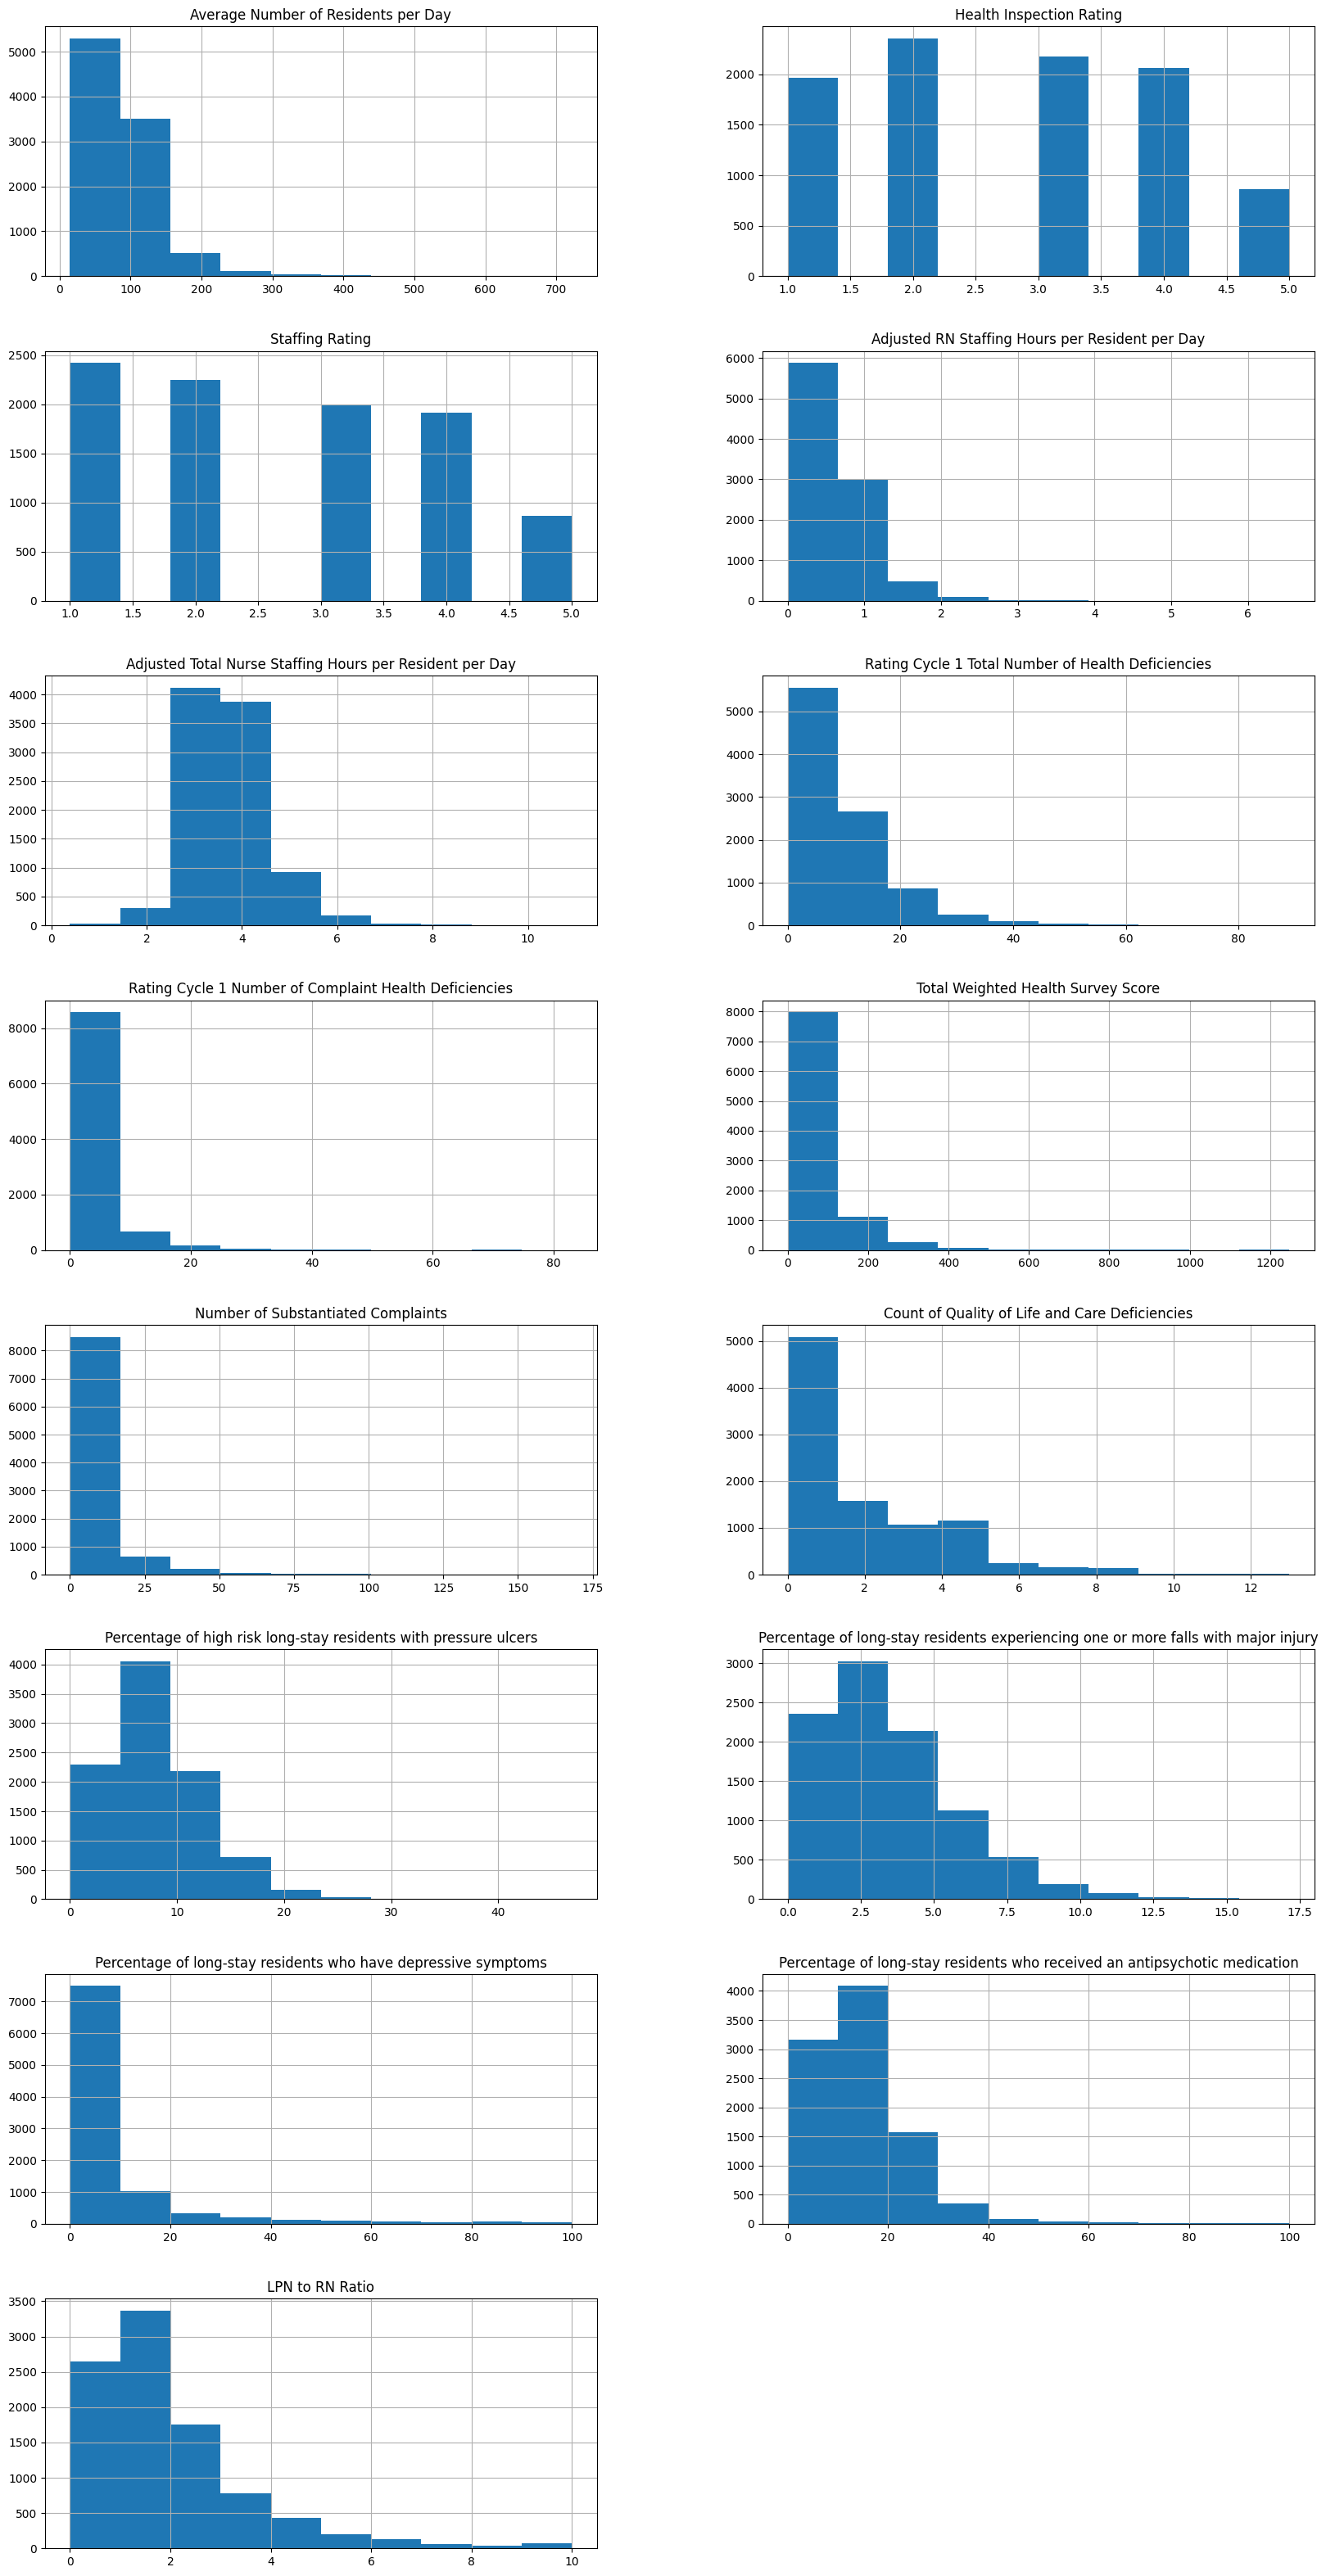

In [20]:
X_train.hist(figsize = (20, 40), layout = (-1,2))

In [21]:
y_train.describe()

count    9481.000000
mean        1.546078
std         0.471968
min         0.669960
25%         1.242451
50%         1.454193
75%         1.731501
max         7.037593
Name: Adjusted Hospitalization Rate, dtype: float64

<Axes: >

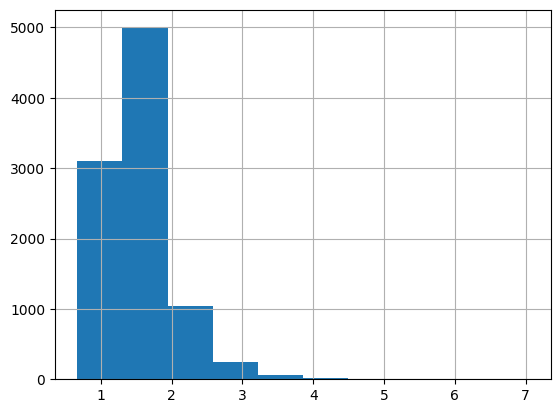

In [22]:
y_train.hist()

<Axes: title={'center': 'Adjusted Hospitalization Rate'}, ylabel='Ownership Type'>

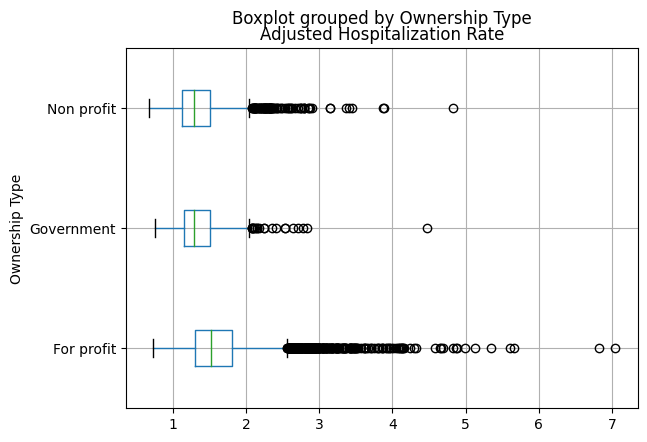

In [23]:
pd.merge(X_train, y_train, left_index = True, right_index = True).boxplot(column = 'Adjusted Hospitalization Rate', by = 'Ownership Type',
            vert = False)

<Axes: title={'center': 'Adjusted Hospitalization Rate'}, ylabel='Provider Type'>

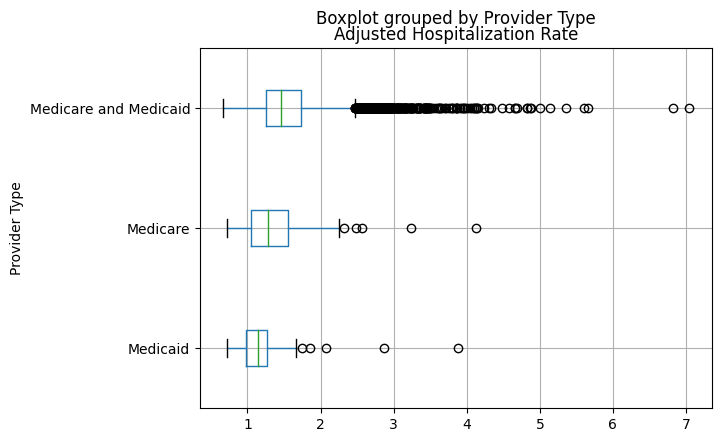

In [24]:
pd.merge(X_train, y_train, left_index = True, right_index = True).boxplot(column = 'Adjusted Hospitalization Rate', by = 'Provider Type',
            vert = False)

<Axes: title={'center': 'Adjusted Hospitalization Rate'}, ylabel='Abuse Icon'>

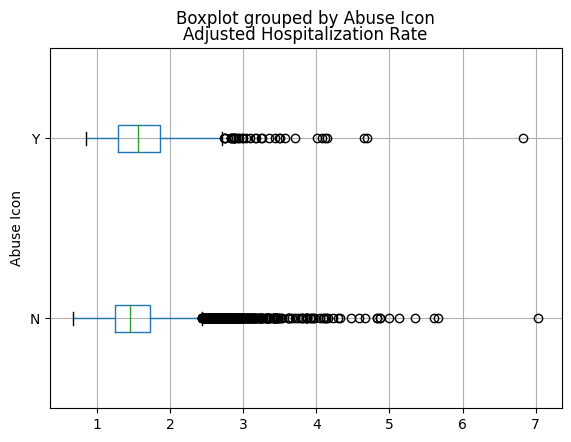

In [25]:
pd.merge(X_train, y_train, left_index = True, right_index = True).boxplot(column = 'Adjusted Hospitalization Rate', by = 'Abuse Icon',
            vert = False)

In [26]:
X_train.dtypes

Ownership Type                                                                         object
Average Number of Residents per Day                                                   float64
Provider Type                                                                          object
Abuse Icon                                                                             object
Health Inspection Rating                                                              float64
Staffing Rating                                                                       float64
Adjusted RN Staffing Hours per Resident per Day                                       float64
Adjusted Total Nurse Staffing Hours per Resident per Day                              float64
Rating Cycle 1 Total Number of Health Deficiencies                                    float64
Rating Cycle 1 Number of Complaint Health Deficiencies                                float64
Total Weighted Health Survey Score                          

# Pre Process Data

The following steps will be performed to pre process the data for better model performance based on data type:  

Numerical Features  

- Transform: Use log or square root transform for features that are right skewed.  

- Scaling: Test out options of MinMaxScaler, StandardScaler, and RobustScaler to reduce impact of outliers, and improve model performance on KNNRegressor.

- Imputing: Some numerical features have missing values. Will impute values using median or KNNImputer.  

Categrical Features  

- One Hot Encoding

In [11]:
# Set up

# Scalers

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Instantiate Transformers
log_transformer = FunctionTransformer(np.log, inverse_func = np.exp, feature_names_out = 'one-to-one')
sqrt_transformer = FunctionTransformer(np.sqrt, feature_names_out = 'one-to-one')

# Instantiate One Hot Encoder for Categorical Features
ohe = OneHotEncoder(drop = 'first')
# Imputers for missing values

k_imputer = KNNImputer(n_neighbors=5)
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')


In [12]:
############### SET INPUTS ################################

df = X_train.copy()
y_input = y_train.copy()

# Choose Scaler to Use

scaler = min_max_scaler # Options: 'min_max_scaler', 'standard_scaler' or 'robust_scaler'

# Choose Imputer to use for Missing Numeric Values (uncomment selected option)

imputer = median_imputer # Options: 'k_imputer', or 'median_imputer'

# List of Features that are Right Skewed

right_skewed_col =  ['Average Number of Residents per Day',
       'Adjusted RN Staffing Hours per Resident per Day',
       'Rating Cycle 1 Total Number of Health Deficiencies',
       'Rating Cycle 1 Number of Complaint Health Deficiencies',
       'Total Weighted Health Survey Score',
       'Number of Substantiated Complaints',
       'Count of Quality of Life and Care Deficiencies',
       'Percentage of high risk long-stay residents with pressure ulcers',
       'Percentage of long-stay residents experiencing one or more falls with major injury',
       'Percentage of long-stay residents who have depressive symptoms',
       'Percentage of long-stay residents who received an antipsychotic medication',
       'LPN to RN Ratio']

####################### Data Pre Processing ##################################


# Seperate Numerical and Categorical Features

cat_features = [i for i in df.columns[df.dtypes == 'object']]
numerical_features = [i for i in df.columns[df.dtypes != 'object']]

# List columns for log and square root transformation

log_col = [column for column in right_skewed_col if (df[column] == 0).any() == False] # If no 0 values, log transform
sqrt_col = [column for column in right_skewed_col if (df[column] == 0).any()] # Else square root transform

# Transform Right Skewed Features

transformer = ColumnTransformer(
     [("log_transform", log_transformer, log_col), # Log transform features with no values equal to 0
      ("sqrt_transformer", sqrt_transformer, sqrt_col)],# Squareroot transform features with some values equal to 0
    remainder='passthrough') # Leaves columns not right skewed as is

# Create Pipeline to Transform Numeric Features
from sklearn.preprocessing import PolynomialFeatures

num_pipeline = Pipeline([
                        #('imputer_missing_values', imputer), # Imputes missing values using chosen imputer
                        ('transform', transformer), # Transforms right skewed features using log or square root
                        #("poly_features", PolynomialFeatures(degree=5, include_bias=False)),
                        ('scaler', scaler), # Scales data using chosen scaler
                        ('imputer_missing_values', imputer) # Imputes missing values using chosen imputer
                    ])

# Combined Transformer for X

ct = ColumnTransformer(
     [("num_pipeline", num_pipeline, numerical_features), # Runs numerical features through pipeline above
      ("one_hot_encoder", ohe, cat_features)]) # One hot encodes categorical features


# Outputs

X_out = ct.fit_transform(df)
y_out = y_input

In [13]:
# Get Feature Names Out and Format for Display
feat_out_raw = ct.get_feature_names_out()

feat_out = [feat.split('__')[-1].replace('_', ': ').replace(': Y', ': Yes') for feat in feat_out_raw]

array([[<Axes: title={'center': 'Average Hospitalizations Transformed'}>]],
      dtype=object)

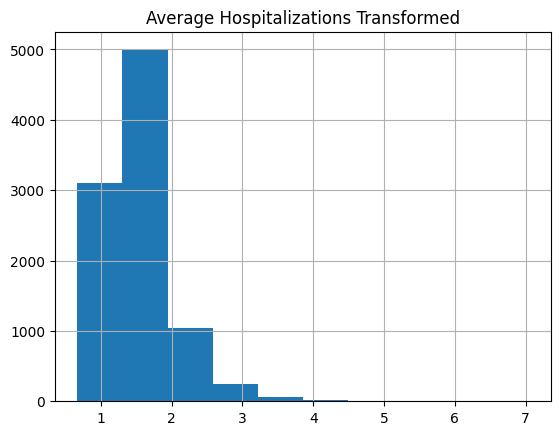

In [30]:
pd.DataFrame({'Average Hospitalizations Transformed' : y_out.ravel()}).hist()

array([[<Axes: title={'center': 'Average Number of Residents per Day'}>,
        <Axes: title={'center': 'Adjusted RN Staffing Hours per Resident per Day'}>],
       [<Axes: title={'center': 'Rating Cycle 1 Total Number of Health Deficiencies'}>,
        <Axes: title={'center': 'Rating Cycle 1 Number of Complaint Health Deficiencies'}>],
       [<Axes: title={'center': 'Total Weighted Health Survey Score'}>,
        <Axes: title={'center': 'Number of Substantiated Complaints'}>],
       [<Axes: title={'center': 'Count of Quality of Life and Care Deficiencies'}>,
        <Axes: title={'center': 'Percentage of high risk long-stay residents with pressure ulcers'}>],
       [<Axes: title={'center': 'Percentage of long-stay residents experiencing one or more falls with major injury'}>,
        <Axes: title={'center': 'Percentage of long-stay residents who have depressive symptoms'}>],
       [<Axes: title={'center': 'Percentage of long-stay residents who received an antipsychotic medication

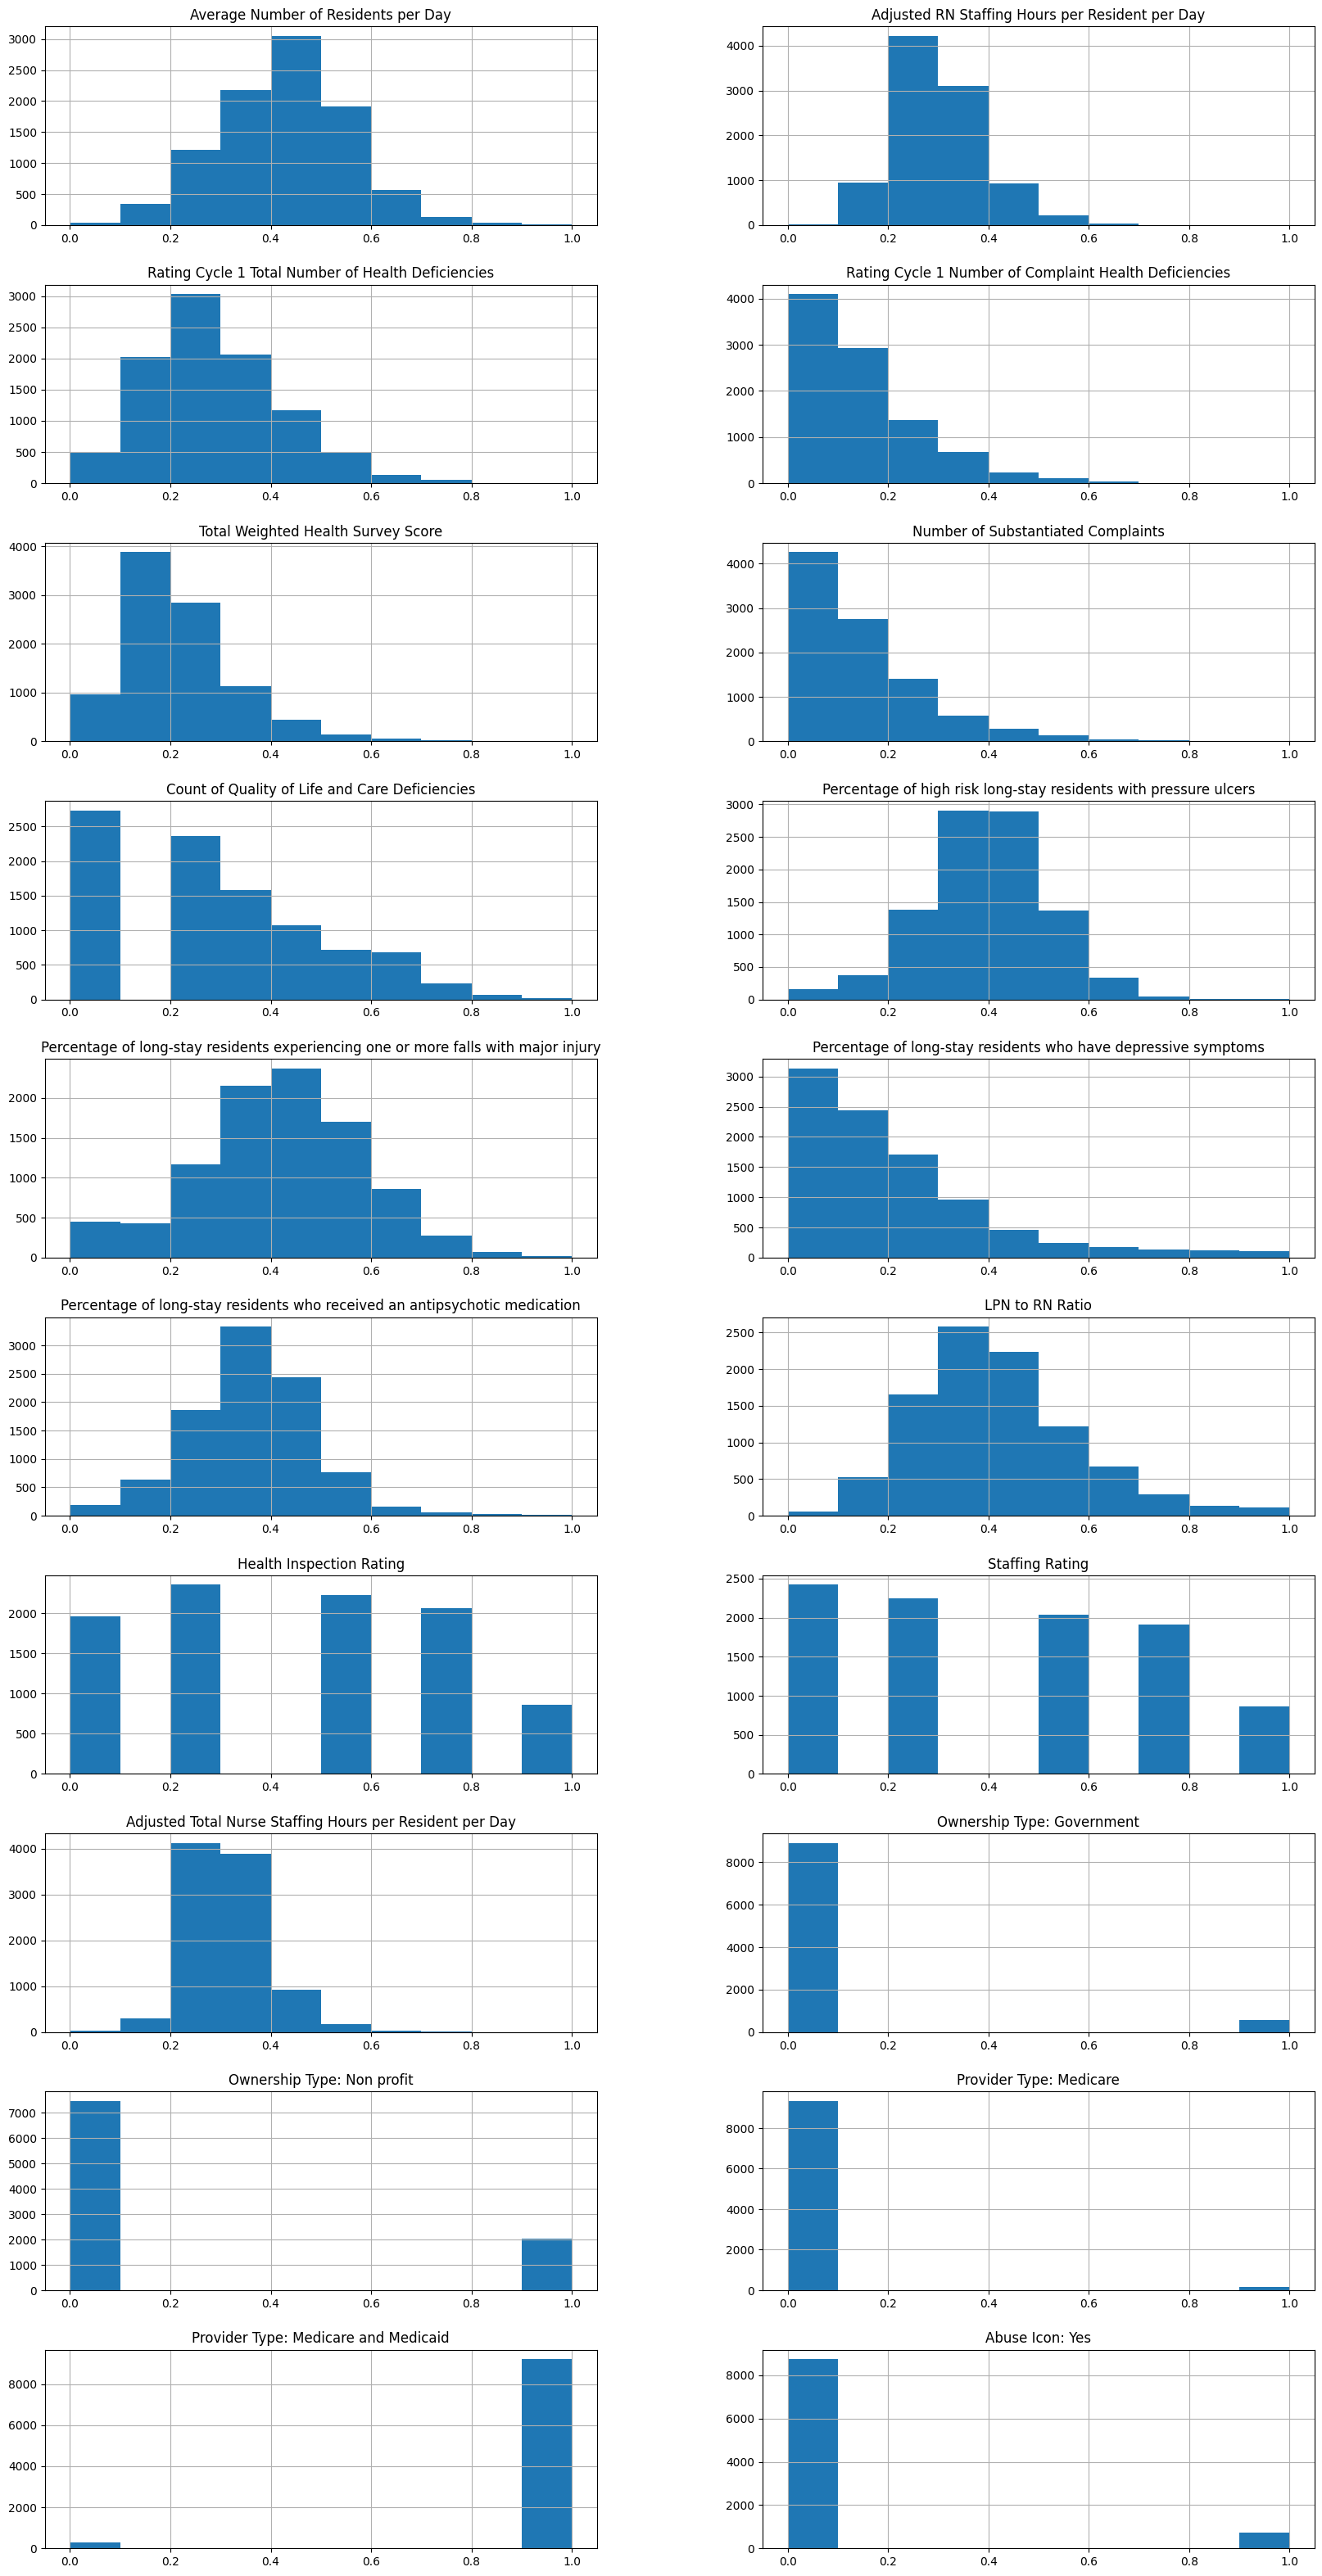

In [31]:
pd.DataFrame(X_out, columns = feat_out).hist(figsize = (20, 40), layout = (-1,2))

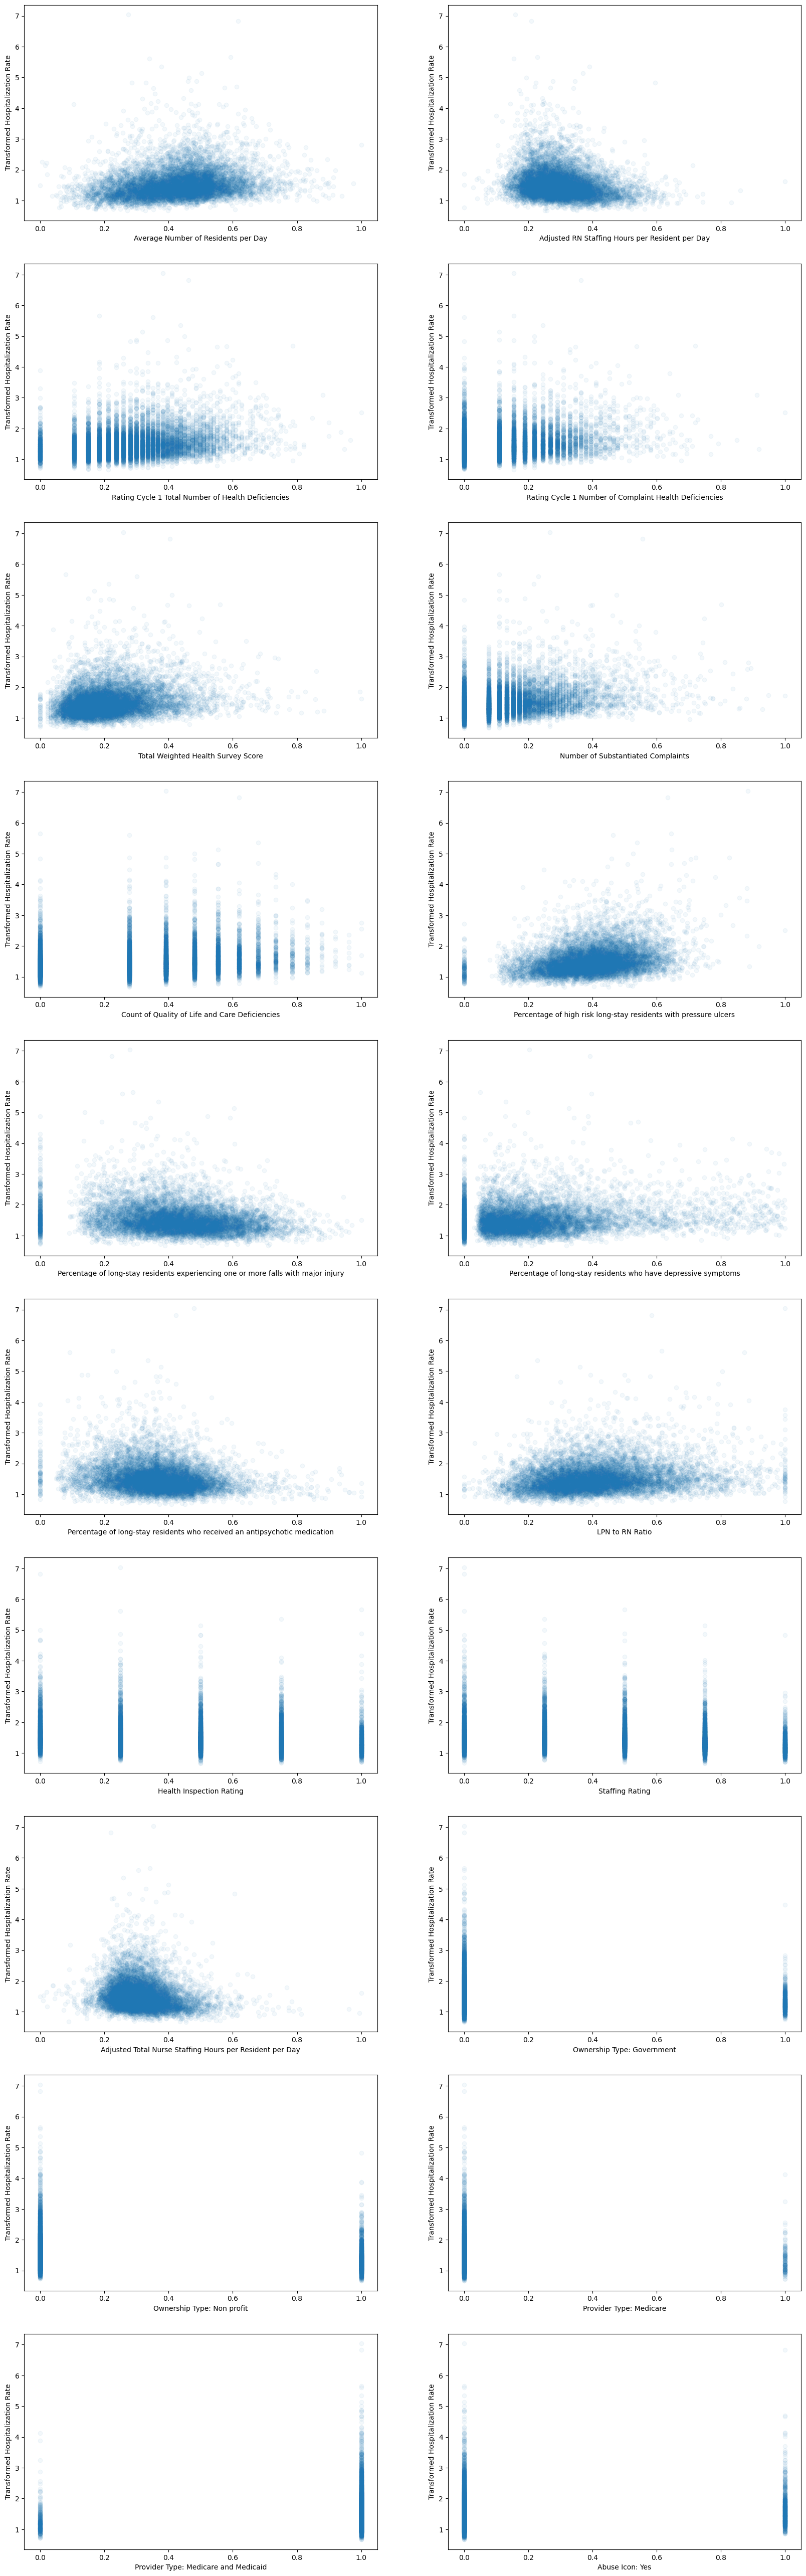

In [32]:
plt.figure(figsize = (20, 200))
num = 1
for column in pd.DataFrame(X_out, columns = feat_out).columns:
    plt.subplot(30,2, num)
    plt.scatter(pd.DataFrame(X_out, columns = feat_out)[column], y_out, alpha = .05)
    plt.xlabel(column)
    plt.ylabel('Transformed Hospitalization Rate')
    num += 1

# <center> Model Selection
    
Will start by training several models with default parameters to shortlist promising models for fine tuning

In [14]:
# Instantiate Models

#####  TREE MODELS #######

# Decision Tree
tree = DecisionTreeRegressor(random_state = 32, max_depth = 5)
# Random Forest Regressor
rfr = RandomForestRegressor(random_state = 32, max_depth = 10, n_estimators = 50, min_samples_leaf = 10, max_features = 0.5)

#### LINEAR MODELS ######

# Linear Regression
lr = LinearRegression()
# Stochastic Gradient Descent
sgd_reg = SGDRegressor(random_state = 32)
# Ridge Regression
ridge = Ridge(random_state = 32)
# Lasso Regression
lasso = Lasso(random_state = 32, alpha = .01)
# Elastic Net Regression
elastic_net = ElasticNet(random_state = 32, alpha = .1)

#### Other Models #####

# Support Vector Regression
svr = SVR()
# K Nearest Neighbors Regressor
knn = KNeighborsRegressor()

In [35]:

# List Models To Test
models = [tree, rfr, lr, sgd_reg, ridge, lasso, elastic_net, svr, knn]

best_score = -1000
for model in models:
    scores = cross_val_score(model, X_out, y_out.ravel(), cv=3, scoring = 'neg_mean_squared_error')
    print(model)
    print(f'Negative Mean Squared Error Scores (MSE): {scores}')
    print(f'Mean Negative MSE {scores.mean()}')
    print(f'Standard Deviation: {scores.std()}\n')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model = model
        best_sd = scores.std()
print(f'Best Model: {best_model} with average negative MSE of {best_score} and standard deviation of {best_sd}')

DecisionTreeRegressor(max_depth=5, random_state=32)
Negative Mean Squared Error Scores (MSE): [-0.19982927 -0.18601548 -0.19372904]
Mean Negative MSE -0.19319126452016974
Standard Deviation: 0.005652261139450668

RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_leaf=10,
                      n_estimators=50, random_state=32)
Negative Mean Squared Error Scores (MSE): [-0.16454912 -0.16575902 -0.17278702]
Mean Negative MSE -0.16769838935810064
Standard Deviation: 0.0036319504318393487

LinearRegression()
Negative Mean Squared Error Scores (MSE): [-0.16506646 -0.1680217  -0.17290723]
Mean Negative MSE -0.16866512738604886
Standard Deviation: 0.0032331517959964464

SGDRegressor(random_state=32)
Negative Mean Squared Error Scores (MSE): [-0.16818944 -0.17457877 -0.17814868]
Mean Negative MSE -0.1736389618468899
Standard Deviation: 0.004119794962185567

Ridge(random_state=32)
Negative Mean Squared Error Scores (MSE): [-0.16499559 -0.1680466  -0.17292934]
Mean Negative MSE -0

The most promising model from this set was Random Forest Regressor with the lowest average Mean Squared Error.

# Artificial Neural Networks

I will test Artificial Neural Network Seperately.

First, I will split out validation data from the test set to allow for early stopping.

In [36]:
X_train_ann, X_valid, y_train_ann, y_valid = train_test_split(X_out, y_out, test_size = .1, random_state = 32)

Create a sample Artificial Neural Network with some default parameters

In [37]:
# Reset Keras and TensorFlow and set random seeds

keras.backend.clear_session()
np.random.seed(32)
tf.random.set_seed(32)
rn.seed(32)

# Create a callback that stops the training early if validation loss is not improving

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

# Model with best parameters found by manually searching

model = keras.models.Sequential([
    keras.layers.Dense(20, input_shape = X_train_ann.shape[1:]),
    keras.layers.Dense(20, activation = 'relu'),
    keras.layers.Dense(1, activation = 'linear')
]) # Build layers
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.SGD(learning_rate = 0.03)) #Compile model

history = model.fit(X_train_ann, y_train_ann,
                    validation_data = (X_valid, y_valid), 
                    epochs = 500, 
                    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]) # Fit model

Epoch 1/500
267/267 [==============================] - 1s 2ms/step - loss: 0.2216 - val_loss: 0.2035
Epoch 2/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1797 - val_loss: 0.1950
Epoch 3/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1728 - val_loss: 0.1907
Epoch 4/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1708 - val_loss: 0.1923
Epoch 5/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1697 - val_loss: 0.1879
Epoch 6/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1687 - val_loss: 0.1867
Epoch 7/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1687 - val_loss: 0.1862
Epoch 8/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1679 - val_loss: 0.1932
Epoch 9/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1677 - val_loss: 0.1863
Epoch 10/500
267/267 [==============================] - 0s 1ms/step - loss: 0.1676 - val_lo

In [38]:
ann_mse = history.model.evaluate(X_valid, y_valid)

print(f'Artificial Neural Network MSE: {ann_mse}')

30/30 [==============================] - 0s 1ms/step - loss: 0.1835
Artificial Neural Network MSE: 0.18347004055976868


# <center> Hyperparameter Tuning

Of the models Random Forest Regression had the lowest MSE. As such I will futher hypertune a Random Forest Regression  

WARNING: The following cells take several hours to run

In [43]:
parameter_grid = {'n_estimators':[2, 8, 16, 64, 128],
                 'max_depth': [2, 5, 10, 15],
                 'min_samples_leaf' : [10, 20, 40],
                 'max_features' : [0.1, 0.25, 0.5, 1]}

searcher = GridSearchCV(rfr, param_grid = parameter_grid, scoring='neg_mean_squared_error', cv=3)

searcher.fit(X_out, y_out)

print("Best Parameters : ",searcher.best_params_)
print("Negative MSE: ", searcher.best_score_)

Best Parameters :  {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 128}
Negative MSE:  -0.16704923142287756


In [44]:
parameter_grid = {'n_estimators':[64, 100, 128, 200],
                 'max_depth': [10, 12, 15, 20, 25],
                 'min_samples_leaf' : [5, 8, 10, 15, 20],
                 'max_features' : [0.25, 0.4, 0.5, 0.75, 1]}

searcher = GridSearchCV(rfr, param_grid = parameter_grid, scoring='neg_mean_squared_error', cv=3)

searcher.fit(X_out, y_out)

print("Best Parameters : ",searcher.best_params_)
print("Negative MSE: ", searcher.best_score_)

Best Parameters :  {'max_depth': 12, 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 200}
Negative MSE:  -0.16626529430675593


In [45]:
parameter_grid = {'n_estimators':[128, 190, 200, 500],
                 'max_depth': [10, 11, 12, 13, 14, 15],
                 'min_samples_leaf' : [2, 5, 6, 8],
                 'max_features' : [0.25, .3, 0.4, 0.45, 0.5]}

searcher = GridSearchCV(rfr, param_grid = parameter_grid, scoring='neg_mean_squared_error', cv=3)

searcher.fit(X_out, y_out)

print("Best Parameters : ",searcher.best_params_)
print("Negative MSE: ", searcher.best_score_)

Best Parameters :  {'max_depth': 14, 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 500}
Negative MSE:  -0.16591986014757792


In [47]:
parameter_grid = {'n_estimators':[300, 500, 600],
                 'max_depth': [14],
                 'min_samples_leaf' : [3, 4, 5],
                 'max_features' : [.35, 0.4]}

searcher = GridSearchCV(rfr, param_grid = parameter_grid, scoring='neg_mean_squared_error', cv=3,
                       n_jobs = -1, verbose = 3)

searcher.fit(X_out, y_out)

print("Best Parameters : ",searcher.best_params_)
print("Negative MSE: ", searcher.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters :  {'max_depth': 14, 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 500}
Negative MSE:  -0.16591986014757792


For the final parameter_grid used n_estimators at increments of 50 as values are large and training is time consuming. Max_features at .05 as that is roughly one feature.

In [48]:
parameter_grid = {'n_estimators':[350, 400, 450, 500, 550],
                 'max_depth': [14],
                 'min_samples_leaf' : [5],
                 'max_features' : [0.4]}

searcher = GridSearchCV(rfr, param_grid = parameter_grid, scoring='neg_mean_squared_error', cv=3,
                       n_jobs = -1, verbose = 3)

searcher.fit(X_out, y_out)

print("Best Parameters : ",searcher.best_params_)
print("Negative MSE: ", searcher.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters :  {'max_depth': 14, 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 550}
Negative MSE:  -0.16591247877296922


# <center> Model Creation
    
    With the best parameters found from Cross Validation I created a RandomForestRegression model and fit it to the training data.

In [51]:
best_model = RandomForestRegressor(random_state = 32, max_depth = 14, max_features = 0.4, min_samples_leaf = 5, n_estimators = 550)
best_model.fit(X_out, y_out)

RandomForestRegressor(max_depth=14, max_features=0.4, min_samples_leaf=5,
                      n_estimators=550, random_state=32)

To make predictions easier a pipeline was created combining the pre processor and the model.

In [52]:
# Create pipeline with both pre-processor and classifier
best_model_pipe = Pipeline([
    ('pre_processor', ct),
    ('model', best_model)
])


# <center> Model Evaluation
    
Model performance was evaluated on MSE and R squared

In [54]:
y_pred = best_model_pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'On the test data set the MSE was {mse}')

On the test data set the MSE was 0.20386829572357631


In [55]:
score = best_model.score(ct.transform(X_test[columns_include]), y_test)

print(f'The R squared score on the test data was {score}')

The R squared score on the test data was 0.2566175119248376


Next I will visualize the predictions to actual values and visualize their accuracy.

In [56]:
results = pd.DataFrame({'Actual Hospitalization Rate' : y_test,
             'Predicted Hospitalization Rate' : y_pred.ravel()})

In [57]:
results['Difference'] = results['Predicted Hospitalization Rate'] - results['Actual Hospitalization Rate']

Create a histogram of the residuals

<Axes: >

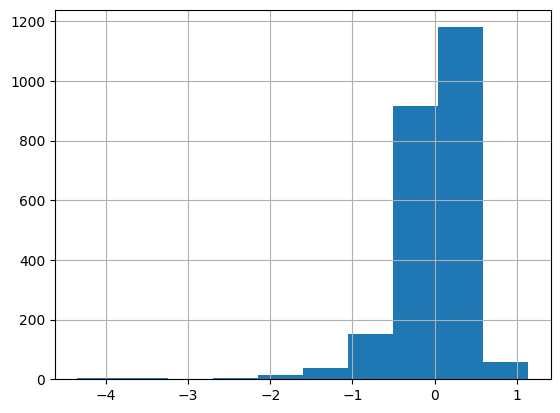

In [58]:
results.Difference.hist()

In [59]:
results.describe()

,Actual Hospitalization Rate,Predicted Hospitalization Rate,Difference
count,2371.000000,2371.000000,2371.000000
mean,1.567797,1.553967,-0.013830
std,0.523794,0.236382,0.451401
min,0.673203,1.080606,-4.346326
25%,1.255939,1.393261,-0.186986
50%,1.468013,1.522354,0.061255
75%,1.737795,1.667269,0.246859
max,7.272010,3.025402,1.139895


Text(0, 0.5, 'Predicted Hospitalization Rate')

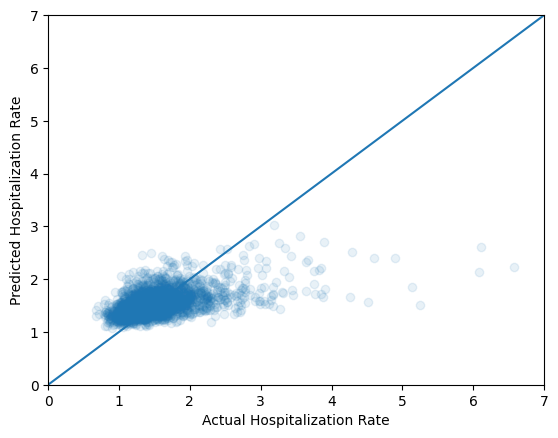

In [60]:
plt.scatter(x = results['Actual Hospitalization Rate'], y = results['Predicted Hospitalization Rate'], alpha = .1)
plt.plot(np.arange(0,8), np.arange(0,8))
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.xlabel('Actual Hospitalization Rate')
plt.ylabel('Predicted Hospitalization Rate')

In [68]:
pd.DataFrame({'Feature Importance' : best_model.feature_importances_}, feat_out).sort_values('Feature Importance',
                                                                                            ascending = False)

,Feature Importance
Percentage of high risk long-stay residents with pressure ulcers,0.183446
Number of Substantiated Complaints,0.126662
Percentage of long-stay residents experiencing one or more falls with major injury,0.092915
Percentage of long-stay residents who received an antipsychotic medication,0.091398
Average Number of Residents per Day,0.072378
Percentage of long-stay residents who have depressive symptoms,0.067777
LPN to RN Ratio,0.060245
Adjusted RN Staffing Hours per Resident per Day,0.057699
Adjusted Total Nurse Staffing Hours per Resident per Day,0.054526
Total Weighted Health Survey Score,0.042962


# <center> Shap Values

## Using Test Data Only (transformed values)

100%|===================| 2367/2371 [08:04<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


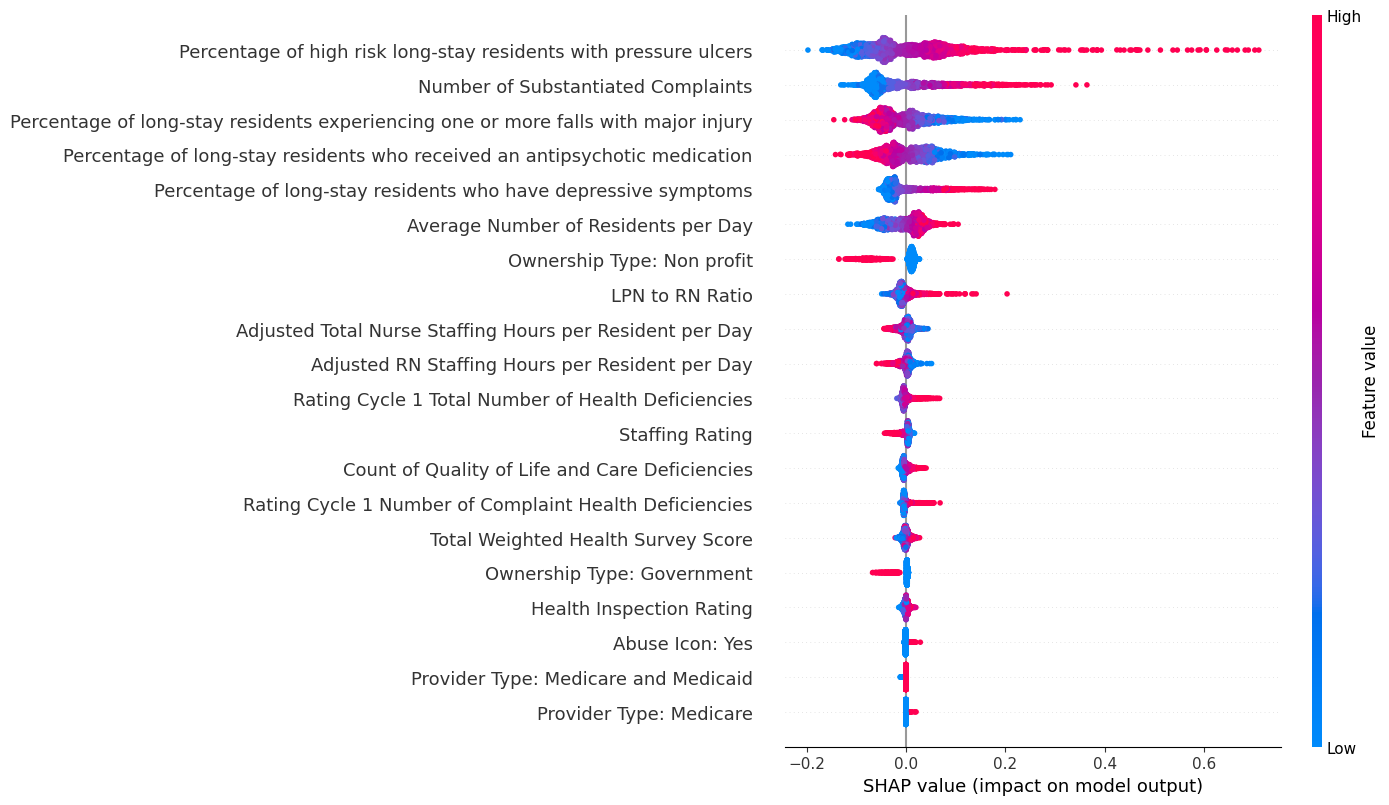

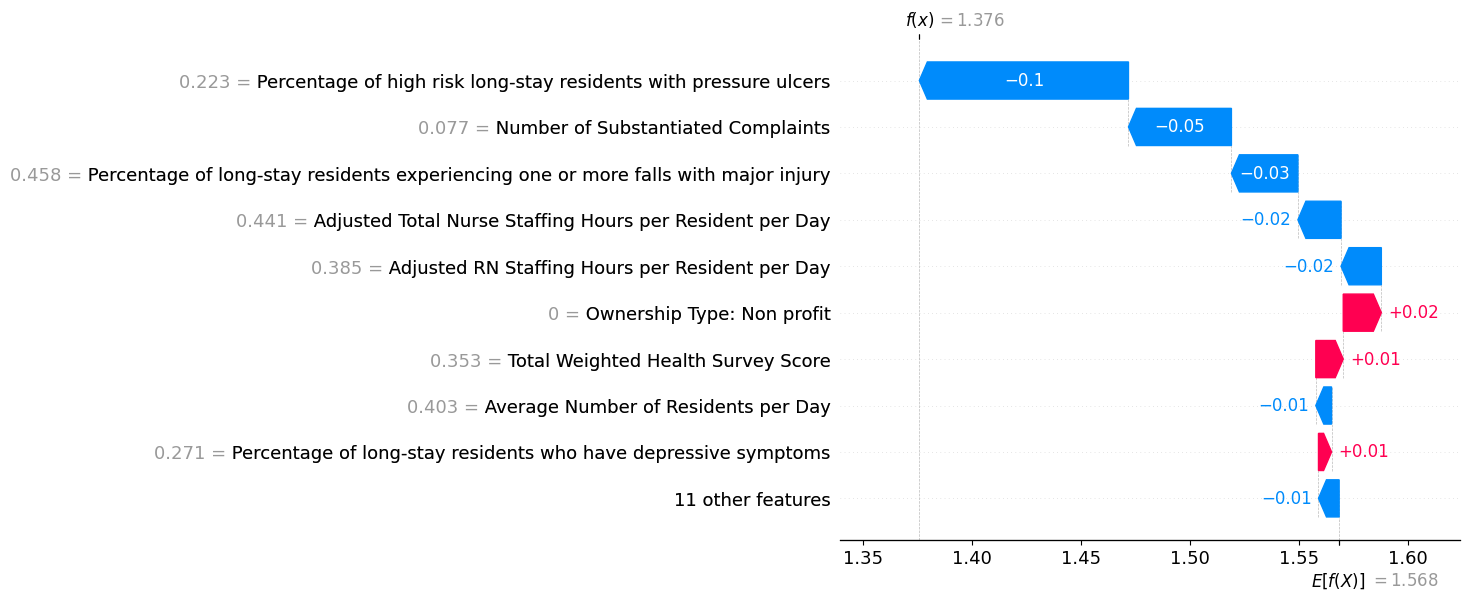

2.149877


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [74]:
X_test_transformed = pd.DataFrame(ct.transform(X_test), columns = feat_out)

explainer = shap.Explainer(best_model, X_test_transformed)
shap_values = explainer(X_test_transformed)

# Visualize Shap Summary Plot
shap.summary_plot(shap_values, X_test_transformed)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
print(y_test[0])

## Prepare for UI

Inverse transform X data frame into original data for use in waterfall chart.

In [75]:
# Transform full X data and include feature names and index

X_transformed = pd.DataFrame(ct.transform(X[columns_include]), columns = feat_out, index = X.index)

# Inverse transform full X data, keeping features in same order as transformed data and number of columns
X_shap = X_transformed.copy()
for column in X_transformed.columns:
    if column in numerical_features: # For numerical features the column name did not change during tranformation.
        X_shap[column] = X[column] 
    else:
        # For categorical One Hot Encoded features the first part of the feature name before ':' is the feature name
        # Replace 0,1 with feature name for easier end-user interpretation
        original_column = column.split(': ', -1)[0]
        X_shap[column] = X[original_column]

Create SHAP explainer with full data set

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


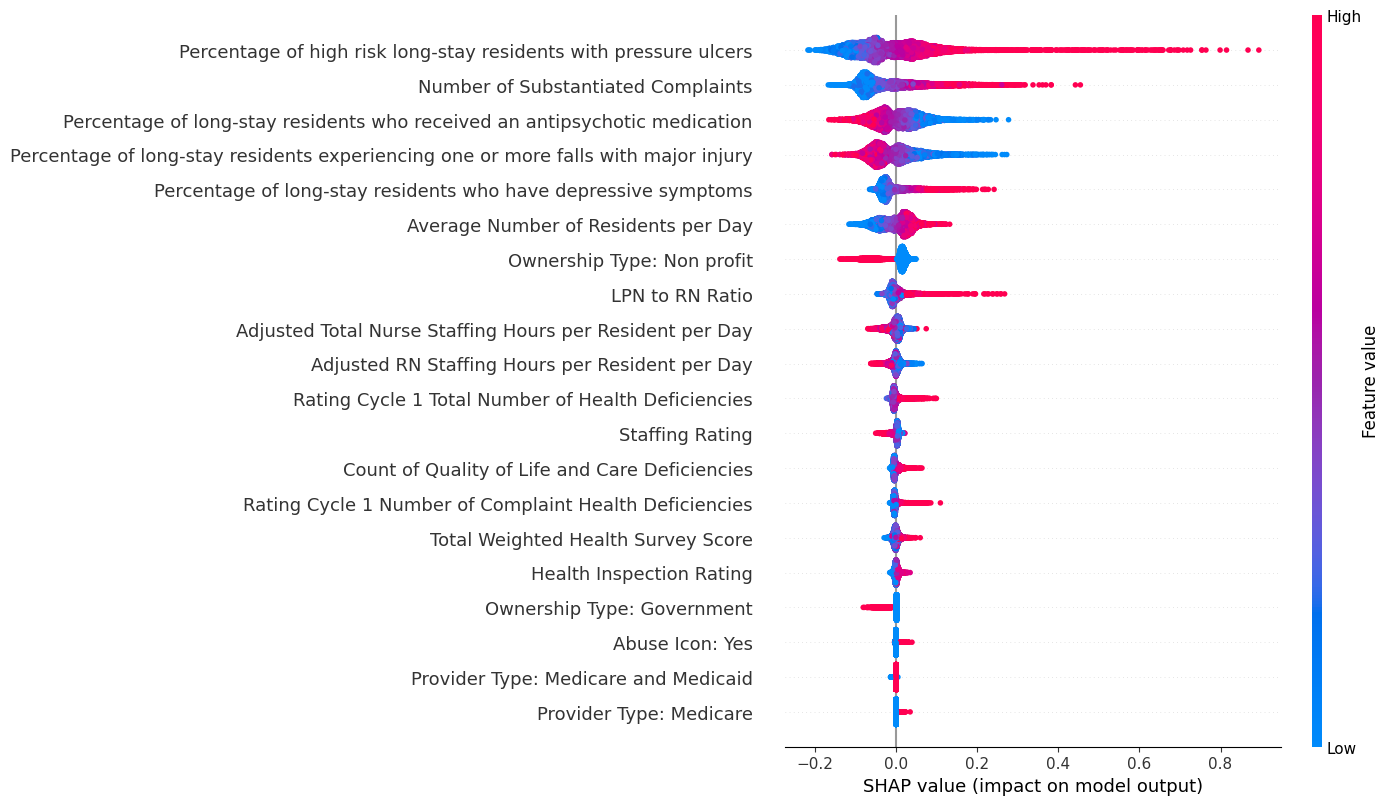

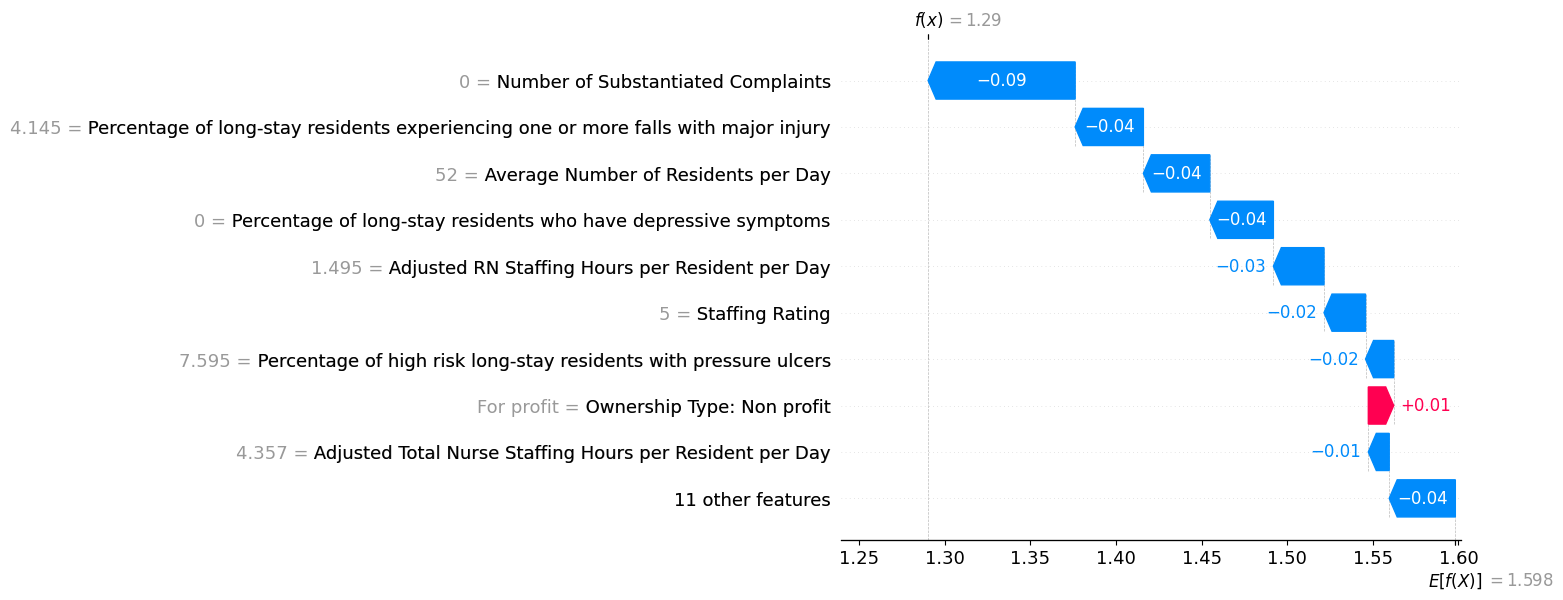

2.149877


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [78]:
# Inverse transform the SHAP explainer using the above created X_shap data frame 

shap_values.data = X_shap.values

# Visualize Shap Summary Plot
shap.summary_plot(shap_values, X_transformed)

# Preview with first row

shap.plots.waterfall(shap_values[0])
print(y_test[0])

Prepare Provider Demographic Data

In [79]:
provider_data = data[['Provider Name', 
          'Provider Address',
           'State',  
           'City/Town', 
           'ZIP Code', 
           'Adjusted Hospitalization Rate']].reset_index()

In [80]:
provider_data.sort_values('Adjusted Hospitalization Rate', ascending = False)

,CMS Certification Number (CCN),Provider Name,Provider Address,State,City/Town,ZIP Code,Adjusted Hospitalization Rate
9824,455815,ASBURY CARE CENTER OF HOUSTON,10851 CRESCENT MOON DR,TX,HOUSTON,77064,7.272010
9154,396143,"TULIP SPECIAL CARE, LLC","3300 HENRY AVENUE, 7TH FLOOR",PA,PHILADELPHIA,19129,7.037593
2629,145718,CRESTWOOD REHABILITATION CTR,14255 SOUTH CICERO AVENUE,IL,CRESTWOOD,60445,6.822620
2604,145671,ELEVATE CARE SOUTH HOLLAND,16300 WAUSAU STREET,IL,SOUTH HOLLAND,60473,6.579847
11569,676064,SPANISH MEADOWS NURSING & REHAB,1480 KATY FLEWELLEN,TX,KATY,77494,6.103075
...,...,...,...,...,...,...,...
5564,245450,THREE LINKS CARE CENTER,815 FOREST AVENUE,MN,NORTHFIELD,55057,0.677937
8969,395704,"LAFAYETTE-REDEEMER, THE",8580 VERREE ROAD,PA,PHILADELPHIA,19111,0.677274
11745,676336,CONTINUING CARE AT EAGLES TRACE,14703 EAGLE VISTA DRIVE BLDG 601B,TX,HOUSTON,77077,0.676422
8870,395552,BETHLEN HM OF THE HUNGARIAN RF OF AMERICA,66 CAREY SCHOOL ROAD,PA,LIGONIER,15658,0.673203


Save `provider_data`, `shap_values`, and `best_model` objects to pickle files to use externally in Flask

In [89]:
joblib.dump(best_model_pipe, 'best_model_pipe.pkl', compress = 1)

joblib.dump(shap_values, 'shap_values.pkl', compress = 1)

joblib.dump(provider_data, 'provider_data.pkl', compress = 1)

joblib.dump(explainer, 'explainer.pkl', compress = 1)

['explainer.pkl']

Preview of desired view on User Interface

Provider Information

CMS Certification Number (CCN)                         455815
Provider Name                   ASBURY CARE CENTER OF HOUSTON
Provider Address                       10851 CRESCENT MOON DR
State                                                      TX
City/Town                                             HOUSTON
ZIP Code                                                77064

Actual Hospitalization Rate (per 1000 patient days): 7.27201

Waterfall Chart - Predicted Hospitalization Rate and feature impacts


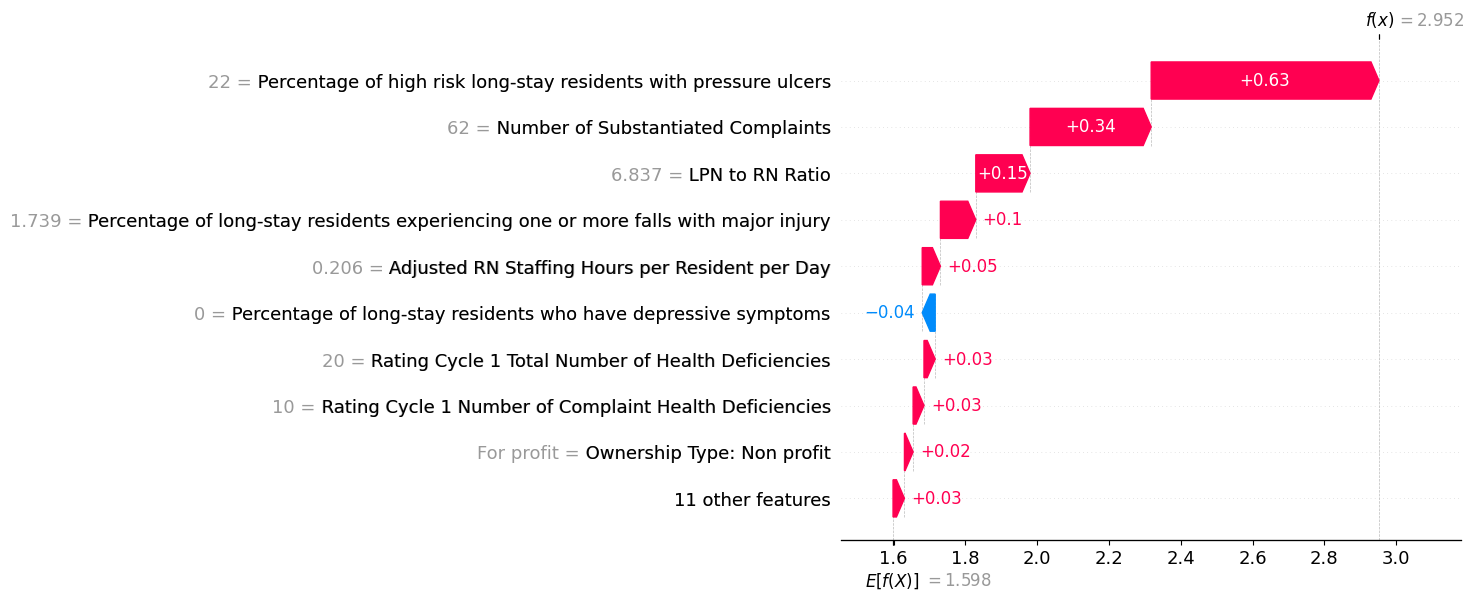

E[f(X)] = national average
f(x) = predicted rate
Bar magnitude = effect of feature on prediction
Features with blue bars decreased prediction and features with red bars increased prediction


In [81]:
# Values from drop down boxes in Flask

state = 'TX'
city = 'HOUSTON'
provider = 'ASBURY CARE CENTER OF HOUSTON'
ccn = '455815'

# Results from Selection

result = provider_data[(provider_data['State'] == state) &
              (provider_data['City/Town'] == city) &
              (provider_data['Provider Name'] == provider) &
              (provider_data['CMS Certification Number (CCN)'] == ccn)]

shap_index = result.index[0]

# Display

print('Provider Information\n')
print(result.drop(columns = 'Adjusted Hospitalization Rate').set_index('CMS Certification Number (CCN)').T)
print(f'\nActual Hospitalization Rate (per 1000 patient days): {result.iloc[0, -1]}')
print('\nWaterfall Chart - Predicted Hospitalization Rate and feature impacts')
shap.plots.waterfall(shap_values[shap_index])
print('E[f(X)] = national average\nf(x) = predicted rate\nBar magnitude = effect of feature on prediction\nFeatures with blue bars decreased prediction and features with red bars increased prediction')